<a href="https://colab.research.google.com/github/rcantini/BERT_text_classification/blob/main/BERT_personality_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Personality detection using BERT**

## Set the environment

### Download the required dependencies

In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 706kB 29.6MB/s 
     |████████████████████████████████| 11.6MB 44.9MB/s 
     |████████████████████████████████| 394.7MB 45kB/s 
     |████████████████████████████████| 9.9MB 16.5MB/s 
     |████████████████████████████████| 22.3MB 1.3MB/s 
     |████████████████████████████████| 1.9MB 46.9MB/s 
     |████████████████████████████████| 2.9MB 49.5MB/s 
     |████████████████████████████████| 3.8MB 36.9MB/s 
     |████████████████████████████████| 471kB 57.3MB/s 
     |████████████████████████████████| 901kB 48.0MB/s 
     |████████████████████████████████| 3.3MB 50.7MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2

### Import necessary libraries

In [42]:
import pandas as pd
from transformers import TFBertModel, BertTokenizer
seed_value = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
np.set_printoptions(precision=2)
import tensorflow as tf
tf.random.set_seed(seed_value)
import tensorflow_addons as tfa
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import ModelCheckpoint
import re
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

In [34]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Personality detection model
I modeled personality detection on the **MBTI** dataset as a multilabel classification task.

In particular, the model treats each personality axis as a separate class, computing an independent probability for each one of them through a Bernuolli trial.

The model is based on **BERT** (HuggingFace Transfromers) and exploits the effectiveness of transfer learning form pre-trained language representation models.

In [43]:
N_AXIS = 4
MAX_SEQ_LEN = 128
BERT_NAME = 'bert-base-uncased'
'''
EMOTIONAL AXES:
Introversion (I) – Extroversion (E)
Intuition (N) – Sensing (S)
Thinking (T) – Feeling (F)
Judging (J) – Perceiving (P)
'''
axes = ["I-E","N-S","T-F","J-P"]
classes = {"I":0, "E":1, # axis 1
           "N":0,"S":1, # axis 2
           "T":0, "F":1, # axis 3
           "J":0,"P":1} # axis 4

### Preprocessing
The following operation are performed: text lowercasing, removing text in square brackets, links, words containing numbers, emoji and initial single quotes.

In [31]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text.encode('ascii', 'ignore').decode('ascii')
    if text.startswith("'"):
        text = text[1:-1]
    return text

Load MBTI data, splitting it into train, val and test skipping the last incomplete batch.

In [51]:
train_n=6624
val_n=1024
test_n=1024
data = pd.read_csv("mbti_1.csv")
data = data.sample(frac=1)
labels = []
print(data)
for personality in data["type"]:
    pers_vect = []
    for p in personality:
        pers_vect.append(classes[p])
    labels.append(pers_vect)
sentences = data["posts"].apply(str).apply(lambda x: text_preprocessing(x))
labels = np.array(labels, dtype="float32")
train_sentences = sentences[:train_n]
y_train = labels[:train_n]
val_sentences = sentences[train_n:train_n+val_n]
y_val = labels[train_n:train_n+val_n]
test_sentences = sentences[train_n+val_n:train_n+val_n+test_n]
y_test = labels[train_n+val_n:train_n+val_n+test_n]

      type                                              posts
5104  INFJ  'Dear ENTP,  You used me and you suck.|||Curre...
231   INFP  'To be fair, as someone who works in the healt...
19    INFP  'That's normal, it happens also to me. If I am...
1895  INTP  'Awkward Hair growing out phase.http://persona...
913   INFP  'For the past two years, I've had a good frien...
...    ...                                                ...
7956  ISFJ  Rebirth! ^-^|||Has anyone determined the type ...
1176  ISFP  'If I could have it my way in real life, chase...
8624  INFJ  http://media.tumblr.com/tumblr_m7aqyr03kG1qcs7...
5660  ESTJ  In matters of romance it comes down to the ind...
6617  ENTP  'Characteristics 1. Smart/Common sense too 2. ...

[8675 rows x 2 columns]


Encode sentences following the BERT specifications

In [33]:
def prepare_bert_input(sentences, seq_len, bert_name):
    tokenizer = BertTokenizer.from_pretrained(bert_name)
    encodings = tokenizer(sentences.tolist(), truncation=True, padding='max_length',
                                max_length=seq_len)
    input = [np.array(encodings["input_ids"]), np.array(encodings["token_type_ids"]),
               np.array(encodings["attention_mask"])]
    return input

In [35]:
X_train = prepare_bert_input(train_sentences, MAX_SEQ_LEN, BERT_NAME)
X_val = prepare_bert_input(val_sentences, MAX_SEQ_LEN, BERT_NAME)
X_test = prepare_bert_input(test_sentences, MAX_SEQ_LEN, BERT_NAME)

### Model architecture

Encoded input is processed by the BERT model. Then, a Global Average Pooling on the sequence of all hidden states is used in order to get a concise representation of the whole sentence. Finally the output sigmoid layer compute an independent probability for each personality axis.

In [36]:
input_ids = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_ids')
input_type = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='token_type_ids')
input_mask = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='attention_mask')
inputs = [input_ids, input_type, input_mask]
bert = TFBertModel.from_pretrained(BERT_NAME)
bert_outputs = bert(inputs)
last_hidden_states = bert_outputs.last_hidden_state
avg = layers.GlobalAveragePooling1D()(last_hidden_states)
output = layers.Dense(N_AXIS, activation="sigmoid")(avg)
model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 token_type_ids[0][0]       

### End-to-end fine-tuning

The model is fully fine-tuned with a small learning rate in order to readapt the pre-trained features to work with our downstream task. I used a binary cross-entropy loss as the prediction for each personality axis is modeled like a single Bernoulli trial, estimating the probability through a sigmoid activation. Moreover I chose the Rectified version of ADAM (RAdam) as the optimizer for the training process. Lastly, I used the area under the Receiver operating characteristic curve (ROC AUC), and binary accuracy as the main metrics for validation and testing.

In [ ]:
max_epochs = 7
batch_size = 32
opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
loss = keras.losses.BinaryCrossentropy()
best_weights_file = "weights.h5"
auc = keras.metrics.AUC(multi_label=True, curve="ROC")
m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_'+auc.name, mode='max', verbose=2,
                          save_weights_only=True, save_best_only=True)
model.compile(loss=loss, optimizer=opt, metrics=[auc, keras.metrics.BinaryAccuracy()])
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    batch_size=batch_size,
    callbacks=[m_ckpt],
    verbose=2
)

Epoch 1/7


### Model evaluation

Evaluate the model on the test set.

In [56]:
loss = keras.losses.BinaryCrossentropy()
best_weights_file = "weights.h5"
model.load_weights(best_weights_file)
opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
model.compile(loss=loss, optimizer=opt, metrics=[keras.metrics.AUC(multi_label=True, curve="ROC"),
                                                  keras.metrics.BinaryAccuracy()])
predictions = model.predict(X_test)
model.evaluate(X_test, y_test, batch_size=32)

32/32 [==============================] - 11s 264ms/step - loss: 0.7481 - auc_12: 0.5401 - binary_accuracy: 0.6554


[0.779860258102417, 0.5176054239273071, 0.63720703125]

Plot ROC AUC for each personality axis.

In [44]:
def plot_roc_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc))
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

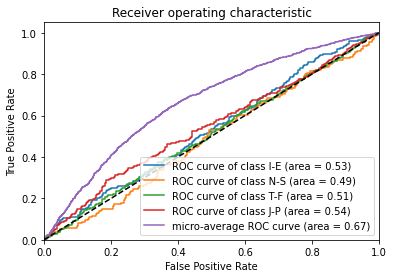

In [55]:
plot_roc_auc(y_test, predictions, axes)

As a final step, I tested the model with a simple sentence for finding out my personality. 

In [49]:
s1 = "I like doing research in the deep learning field, playing football and hanging out with my friends," \
     "listen to music and visit foreign cities all over the world."
sentences = np.asarray([s1])
enc_sentences = prepare_bert_input(sentences, MAX_SEQ_LEN, BERT_NAME)
predictions = model.predict(enc_sentences)
for sentence, pred in zip(sentences, predictions):
    pred_axis = []
    mask = (pred > 0.5).astype(bool)
    for i in range(len(mask)):
        if mask[i]:
            pred_axis.append(axes[i][2])
        else:
            pred_axis.append(axes[i][0])
    print('-- comment: '+sentence.replace("\n", "").strip() +
          '\n-- personality: '+str(pred_axis) +
          '\n-- scores:'+str(pred))

-- comment: I like doing research in the deep learning field, playing football and hanging out with my friends,listen to music and visit foreign cities all over the world.
-- personality: ['I', 'N', 'F', 'P']
-- scores:[0.25 0.45 0.52 0.75]
